In [1]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Activation,Embedding,RepeatVector,TimeDistributed,GRU
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback

from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\kahraman\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
df = pd.read_csv('h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,45.0,1.0,1.521928,Aria
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,1.0,60.0,0.0,0.000000,Aria


In [3]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(270000, 25)

In [4]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [5]:
p=[]
for i in y:
    if i not in p:
        p.append(i)
        
for i,ii in enumerate (p)  :
    print(i,ii)
    

0 Aria
1 D-LinkCam
2 D-LinkDayCam
3 D-LinkDoorSensor
4 D-LinkHomeHub
5 D-LinkSensor
6 D-LinkSiren
7 D-LinkSwitch
8 D-LinkWaterSensor
9 EdimaxCam
10 EdimaxPlug1101W
11 EdimaxPlug2101W
12 EdnetCam
13 EdnetGateway
14 HomeMaticPlug
15 HueBridge
16 HueSwitch
17 IKettle2
18 Lightify
19 MAXGateway
20 SmarterCoffee
21 TP-LinkPlugHS100
22 TP-LinkPlugHS110
23 WeMoInsightSwitch
24 WeMoLink
25 WeMoSwitch
26 Withings


In [6]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [7]:
p=[]
for i in y:

    if str(i)not in p:
        p.append(str(i))
        
for i,ii in enumerate (p)  :
    print(i,ii)
    

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26


In [8]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [9]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [11]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [12]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

In [13]:
# define LSTM
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
model.add(GRU(50, return_sequences=True))
model.add(TimeDistributed(Dense(27, activation= "softmax" )))
#model.compile(loss= "categorical_crossentropy" , optimizer= "adam" , metrics=[ "accuracy" ])

#model.add(Dense(Y_train.shape[1], activation='softmax'))

nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                11400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 50)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 50)             15150     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 27)             1377      
Total params: 27,927
Trainable params: 27,927
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
Y_train.shape

(216000, 27)

In [15]:
Y_train = np.reshape(Y_train, (Y_train.shape[0],1 , Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0], 1, Y_val.shape[1]))

In [16]:

hdf5FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(hdf5FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)

In [17]:
#Time to train

start_time = time.time()



history=model.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=2, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))

from keras.models import load_model

model.save(hdf5FileName[:-3])  # creates a HDF5 file 'my_model.h5'



Train on 216000 samples, validate on 54000 samples
Epoch 1/50
 - 137s - loss: 2.4041 - acc: 0.2443 - val_loss: 2.0593 - val_acc: 0.3132

Epoch 00001: val_acc improved from -inf to 0.31324, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 2/50
 - 111s - loss: 1.8096 - acc: 0.4026 - val_loss: 1.6073 - val_acc: 0.4585

Epoch 00002: val_acc improved from 0.31324 to 0.45850, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/50
 - 115s - loss: 1.4769 - acc: 0.4875 - val_loss: 1.3821 - val_acc: 0.5203

Epoch 00003: val_acc improved from 0.45850 to 0.52031, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/50
 - 113s - loss: 1.3467 - acc: 0.5175 - val_loss: 1.2697 - val_acc: 0.5512

Epoch 00004: val_acc improved from 0.52031 to 0.55120, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 5/50
 - 114s - loss: 1.2749 - acc: 0.5339 - val_loss: 1.2067 - val_acc: 0.5560

Epoch 00005: val_acc improved from 0.55120 to 0.55604, saving model to

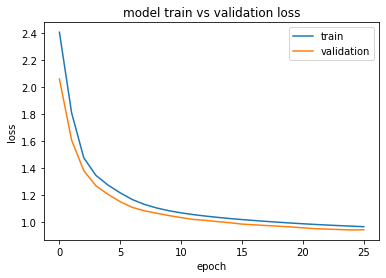

In [18]:


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array
 

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

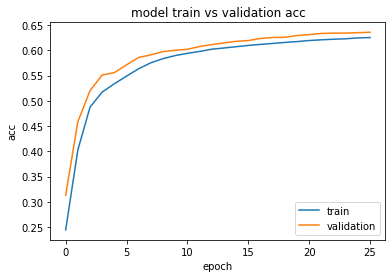

In [19]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [20]:
df = pd.read_csv('h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria
1,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,765,1,5.567481,Aria
2,0,0,0,1,0,0,1,0,29200,1,...,0,0,4,0,1,2,48,0,0.000000,Aria
3,1,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0.000000,Aria
4,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria


In [21]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))


In [22]:
Y_test = np.reshape(y, (y.shape[0],  1,y.shape[1]))
Y_test

array([[[1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]]])

## TEST DEĞERLENDİRME

In [23]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=1)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
#predicted = model.predict(X_test)

81000/81000 [==============================] - 174s 2ms/step
Loss for testing = 1.0087793740571231 and Accuracy for testing = 0.6186666666666667


In [24]:
predicted = model.predict(X_test,verbose=0)



In [25]:
predicted

array([[[1.0000000e+00, 2.3827432e-10, 1.1489237e-09, ...,
         5.8323417e-18, 2.4255303e-17, 1.0675029e-09]],

       [[9.8788387e-01, 2.0449485e-04, 3.0910535e-04, ...,
         3.1392938e-13, 3.3777102e-03, 2.6875818e-03]],

       [[1.1223907e-01, 3.3300751e-04, 4.1650001e-06, ...,
         5.4919888e-04, 3.0789556e-04, 4.0468502e-01]],

       ...,

       [[5.9558827e-02, 3.0182136e-04, 2.3143643e-06, ...,
         1.2545919e-06, 7.9883685e-06, 8.4374040e-01]],

       [[1.8077096e-02, 1.3807265e-08, 3.0850028e-06, ...,
         2.2265085e-03, 2.7148076e-04, 6.2862951e-01]],

       [[5.9542730e-02, 3.0204022e-04, 2.3161870e-06, ...,
         1.2562028e-06, 7.9984811e-06, 8.4367085e-01]]], dtype=float32)

In [26]:
(X_test.shape)

(81000, 1, 25)

In [27]:
#predicted = model.predict(X_test)

In [28]:
(predicted.shape)

(81000, 1, 27)

In [29]:
"""

for i in X_test:
    temp=i
    print(temp.shape) #(predicted)
    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))
    print(temp.shape) #(predicted)
    predicted = model.predict(temp,batch_size=1000)
    print(predicted)
    break
"""

'\n\nfor i in X_test:\n    temp=i\n    print(temp.shape) #(predicted)\n    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))\n    print(temp.shape) #(predicted)\n    predicted = model.predict(temp,batch_size=1000)\n    print(predicted)\n    break\n'

### grafik mırafik

In [30]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    return df_confusion
"""   
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    """ 

'   \n    predicted= np.array(predicted).tolist()\n    Y_test = np.array(Y_test).tolist()\n\n    n_classes = 27\n    print("n_classes is: ", n_classes)\n    Y_test= np.asarray(Y_test)\n    predicted = np.asarray(predicted)\n    \n    fpr = dict()\n    tpr = dict()\n    roc_auc = dict()\n    for i in range(n_classes):\n        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])\n        roc_auc[i] = auc(fpr[i], tpr[i])\n\n    # Compute micro-average ROC curve and ROC area\n    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())\n    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])\n    \n    lw = 2\n    # Compute macro-average ROC curve and ROC area\n    #First aggregate all false positive rates\n    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))\n\n    # Then interpolate all ROC curves at this points\n    mean_tpr = np.zeros_like(all_fpr)\n    for i in range(n_classes):\n        mean_tpr += interp(all_fpr, fpr[i], tpr[i])\n\n

In [31]:
predicted

array([[[1.0000000e+00, 2.3827432e-10, 1.1489237e-09, ...,
         5.8323417e-18, 2.4255303e-17, 1.0675029e-09]],

       [[9.8788387e-01, 2.0449485e-04, 3.0910535e-04, ...,
         3.1392938e-13, 3.3777102e-03, 2.6875818e-03]],

       [[1.1223907e-01, 3.3300751e-04, 4.1650001e-06, ...,
         5.4919888e-04, 3.0789556e-04, 4.0468502e-01]],

       ...,

       [[5.9558827e-02, 3.0182136e-04, 2.3143643e-06, ...,
         1.2545919e-06, 7.9883685e-06, 8.4374040e-01]],

       [[1.8077096e-02, 1.3807265e-08, 3.0850028e-06, ...,
         2.2265085e-03, 2.7148076e-04, 6.2862951e-01]],

       [[5.9542730e-02, 3.0204022e-04, 2.3161870e-06, ...,
         1.2562028e-06, 7.9984811e-06, 8.4367085e-01]]], dtype=float32)

In [32]:
print(predicted.shape, Y_test.shape)

(81000, 1, 27) (81000, 1, 27)


In [33]:
df_cm=compute_metrics(predicted, Y_test)

Average F1 score is 0.6158816357857652
Confusion matrix: 
 Predicted    0     1     2     3     4    5    6    7    8     9   ...    17  \
Actual                                                             ...         
0          2317     0     0     0     0    0    0    0    0     0  ...   327   
1             1  2418    65     0     2   19  161   28   48    42  ...    26   
2            19     0  2533     0     0    0    0    0    0   300  ...    48   
3            32     8    40  2785     0    0    0    2   56     0  ...     0   
4             4   219     5     2  1664   27  212  331  188     0  ...    14   
5            12   194     7    18   177  218  678  711  675     7  ...    15   
6             0   174     4    21   113  114  784  694  797     7  ...     9   
7             0   161    10    12   351  105  745  336  995     9  ...     8   
8             0   176     8    24   129  258  678  640  786     7  ...     6   
9            41     0   408     0     0    0    0    0    0  

In [34]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

ValueError: multilabel-indicator is not supported

In [35]:
cm=df_cm.values

In [37]:
cm

array([[2317,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   53,    0,    0,    0,    0,  327,    0,    0,  177,    0,
          10,    0,    0,    0,  116],
       [   1, 2418,   65,    0,    2,   19,  161,   28,   48,   42,    3,
          38,    8,    7,    0,   19,   32,   26,    3,    0,   22,    7,
           6,   30,    0,   15,    0],
       [  19,    0, 2533,    0,    0,    0,    0,    0,    0,  300,    0,
           0,   40,    0,    0,    0,    0,   48,    0,    0,   60,    0,
           0,    0,    0,    0,    0],
       [  32,    8,   40, 2785,    0,    0,    0,    2,   56,    0,    3,
           0,    0,    4,    0,    0,    0,    0,    9,    6,   22,    8,
          12,    1,    0,   12,    0],
       [   4,  219,    5,    2, 1664,   27,  212,  331,  188,    0,   20,
          16,    5,    9,    0,  129,   33,   14,   34,    4,    7,    7,
           2,   63,    2,    1,    2],
       [  12,  194,    7,   18,  177,  218,  678,  711,  675,    

In [2]:
cm=[[2317,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   53,    0,    0,    0,    0,  327,    0,    0,  177,    0,
          10,    0,    0,    0,  116],
       [   1, 2418,   65,    0,    2,   19,  161,   28,   48,   42,    3,
          38,    8,    7,    0,   19,   32,   26,    3,    0,   22,    7,
           6,   30,    0,   15,    0],
       [  19,    0, 2533,    0,    0,    0,    0,    0,    0,  300,    0,
           0,   40,    0,    0,    0,    0,   48,    0,    0,   60,    0,
           0,    0,    0,    0,    0],
       [  32,    8,   40, 2785,    0,    0,    0,    2,   56,    0,    3,
           0,    0,    4,    0,    0,    0,    0,    9,    6,   22,    8,
          12,    1,    0,   12,    0],
       [   4,  219,    5,    2, 1664,   27,  212,  331,  188,    0,   20,
          16,    5,    9,    0,  129,   33,   14,   34,    4,    7,    7,
           2,   63,    2,    1,    2],
       [  12,  194,    7,   18,  177,  218,  678,  711,  675,    7,   21,
          14,   13,   22,    0,   23,   19,   15,   73,    4,   13,    0,
           5,   71,    0,    0,   10],
       [   0,  174,    4,   21,  113,  114,  784,  694,  797,    7,   42,
          24,   24,   14,    0,   29,    3,    9,   55,    6,   18,    8,
           4,   51,    0,    0,    5],
       [   0,  161,   10,   12,  351,  105,  745,  336,  995,    9,   29,
          23,   13,   21,    0,   32,    7,    8,   45,    1,   20,   18,
           1,   54,    0,    1,    3],
       [   0,  176,    8,   24,  129,  258,  678,  640,  786,    7,   34,
          20,   27,   16,    0,   26,    1,    6,   66,    2,   15,    4,
           5,   65,    0,    0,    7],
       [  41,    0,  408,    0,    0,    0,    0,    0,    0, 2274,   10,
           0,   96,    0,    0,    0,    0,   58,    0,    0,  113,    0,
           0,    0,    0,    0,    0],
       [  63,    9,   44,   29,    0,    0,    0,    0,    0,   67, 1442,
        1031,   33,   21,    0,    0,   52,   27,    0,   25,    0,   48,
           0,   32,    0,   77,    0],
       [  75,    0,   91,   33,    0,    0,    0,    0,    0,   90, 1106,
        1190,   56,   18,    0,    0,   69,   35,    9,   19,   23,   69,
          61,   11,    0,   45,    0],
       [   0,    0,    0,    0,   93,    0,    0,    0,    0,  104,    0,
           0, 2058,    0,    0,    0,    0,  426,    0,    0,  319,    0,
           0,    0,    0,    0,    0],
       [  20,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   38, 2466,    0,    0,    0,  197,    0,    0,  204,   12,
          38,   16,    0,    0,    9],
       [   0,    0,   33,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 2896,    0,    0,    0,    0,    0,   71,    0,
           0,    0,    0,    0,    0],
       [   1,   34,    0,   18,   79,   19,    5,    5,   21,    6,   23,
          14,    5,    6,    0, 2617,   79,    1,    0,    2,   15,    5,
           8,   33,    0,    1,    3],
       [   0,    8,    5,    0,    1,    3,    0,    0,    0,    2,    0,
           2,    0,    2,    0,    0, 2750,    0,    0,    0,    0,    6,
           2,    3,    0,    0,  216],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  253,    0,    0,    0,    0, 1322,    0,    0, 1425,    0,
           0,    0,    0,    0,    0],
       [  18,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    2,  112,    0,    0,    0,   35, 2788,    8,   30,    6,
           1,    0,    0,    0,    0],
       [   0,    0,  104,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   27,    0,    0,   45,   51,    9, 2501,    8,   80,
         144,    0,    0,    0,   31],
       [   0,    0,  124,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  377,    0,    0,    0,    0, 1220,    0,    0, 1279,    0,
           0,    0,    0,    0,    0],
       [  39,    0,   35,    0,    0,    4,    0,    0,    6,   26,   48,
           0,   83,   32,   14,    0,    0,  125,    9,   67,  161, 1036,
        1281,   34,    0,    0,    0],
       [  13,    0,    0,    0,    0,    0,    0,    0,    6,   56,   78,
          65,  113,    7,    9,    0,    0,  167,    0,   61,   96,  927,
        1296,   66,    0,   40,    0],
       [   0,   10,   35,  130,   57,    3,    0,    5,    0,   67,   21,
          29,   47,    6,    0,   66,    0,   23,    0,   18,   20,    5,
          11, 1709,  647,   91,    0],
       [   0,    4,    0,   46,   65,    4,    8,    0,    5,    0,   15,
          24,    3,    7,    2,   35,    0,   19,    0,   11,   30,   14,
           1,  592, 1915,  198,    2],
       [   0,   27,   10,    0,    0,    0,    0,    5,    6,    0,   44,
          29,    8,    5,    0,    0,    0,   38,    0,   51,   42,   29,
          24,  105,    1, 2576,    0],
       [ 261,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   40,    0,    0,    0,    0,  223,    0,    0,  234,    0,
          62,   24,    0,    0, 2156]]

In [36]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")
    
    
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
accuracy(cm)

label precision recall fscore
    0     0.795  0.772  0.783
    1     0.702  0.806  0.751
    2     0.711  0.844  0.772
    3     0.893  0.928  0.910
    4     0.609  0.555  0.581
    5     0.282  0.073  0.116
    6     0.240  0.261  0.250
    7     0.122  0.112  0.117
    8     0.219  0.262  0.239
    9     0.742  0.758  0.750
   10     0.491  0.481  0.486
   11     0.472  0.397  0.431
   12     0.606  0.686  0.644
   13     0.880  0.822  0.850
   14     0.991  0.965  0.978
   15     0.879  0.872  0.876
   16     0.890  0.917  0.903
   17     0.299  0.441  0.356
   18     0.899  0.929  0.914
   19     0.898  0.834  0.865
   20     0.289  0.426  0.345
   21     0.453  0.345  0.392
   22     0.436  0.432  0.434
   23     0.577  0.570  0.573
   24     0.747  0.638  0.688
   25     0.843  0.859  0.851
   26     0.842  0.719  0.776


0.6186666666666667

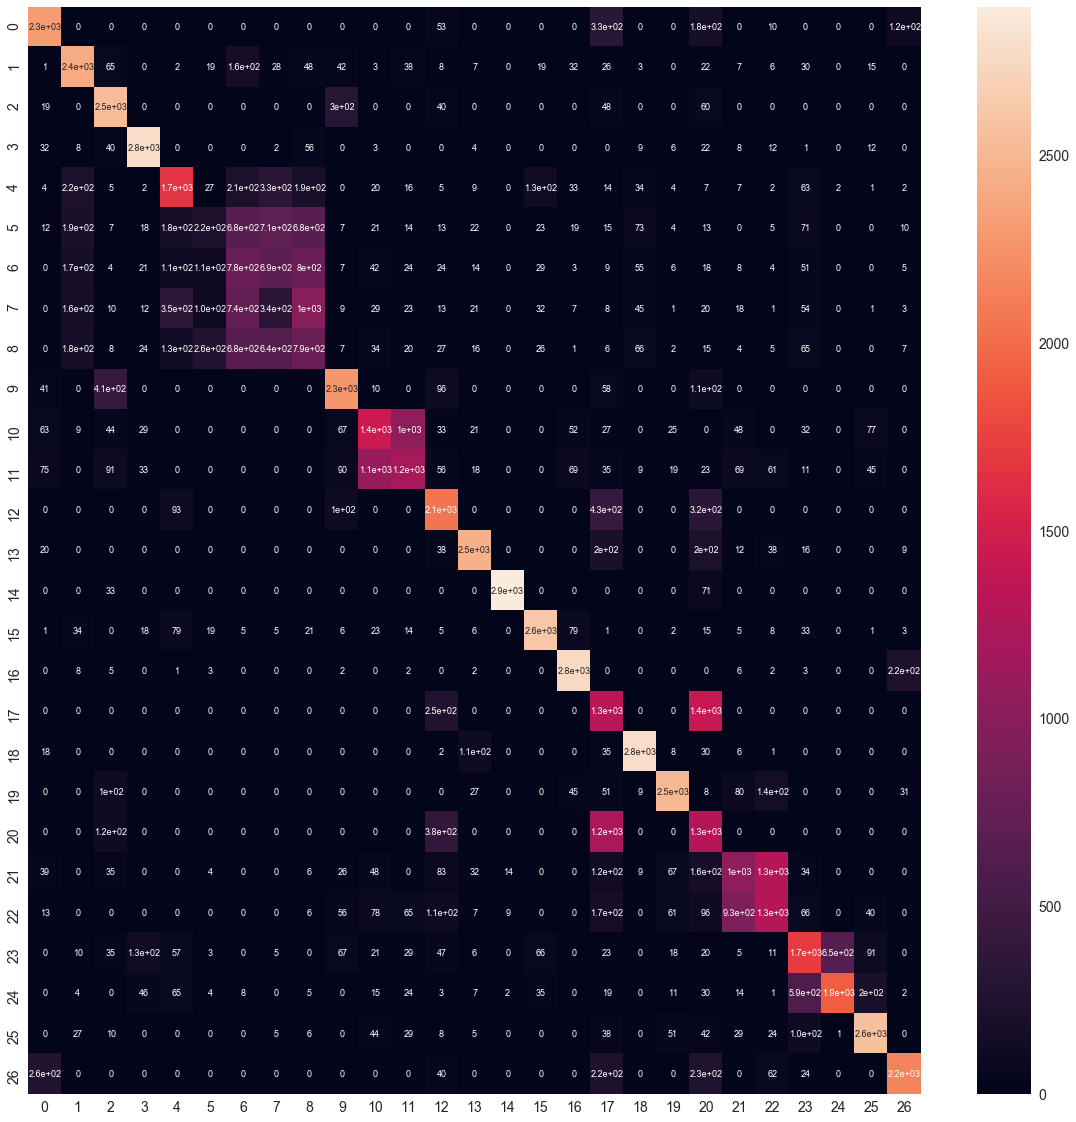

In [3]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(cm, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

## MODEL SAVING RELOADING

In [ ]:
from keras.models import load_model

model.save('54.h5')  # creates a HDF5 file 'my_model.h5'



In [ ]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')